In [ ]:
# Install dependencies
!pip install fastbook
!pip install ipywidgets

In [ ]:
# Import dependencies
import fastbook
fastbook.setup_book()
from fastbook import *
from ipywidgets import *
from fastai.vision.widgets import *

In [3]:
path = Path('data')

In [ ]:
# Bing search key
key = os.environ.get('AZURE_SEARCH_KEY', '43e75ba8cc4e48558f4a625fa1e4f18b')
# Get images for each bill
billFolders = ['one dollar us bill', 'five dollar us bill', 'ten dollar us bill', 'twenty dollar us bill',
               'fifty dollar us bill','hundred dollar us bill']

# Create directories if needed
if not path.exists():
    path.mkdir()
    for billFolder in billFolders:
        # Create folder name
        billFolderName = billFolder.split()
        del billFolderName[2]
        billFolderName = "_".join(billFolderName)
        
        dest = (path/billFolderName)
        dest.mkdir(exist_ok=True)
        
        # Search bing for the bills
        results = search_images_bing(key, f'{billFolder}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [4]:
# Get folder images
fns = get_image_files(path)
fns

(#2755) [Path('data/fifty_dollar_bills/00000002.jpg'),Path('data/fifty_dollar_bills/00000003.png'),Path('data/fifty_dollar_bills/00000004.jpg'),Path('data/fifty_dollar_bills/00000005.jpg'),Path('data/fifty_dollar_bills/00000006.jpg'),Path('data/fifty_dollar_bills/00000007.png'),Path('data/fifty_dollar_bills/00000008.jpg'),Path('data/fifty_dollar_bills/00000009.jpg'),Path('data/fifty_dollar_bills/00000010.jpg'),Path('data/fifty_dollar_bills/00000011.jpg')...]

In [5]:
# Remove corrupted images
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [6]:
# Create datablock template
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


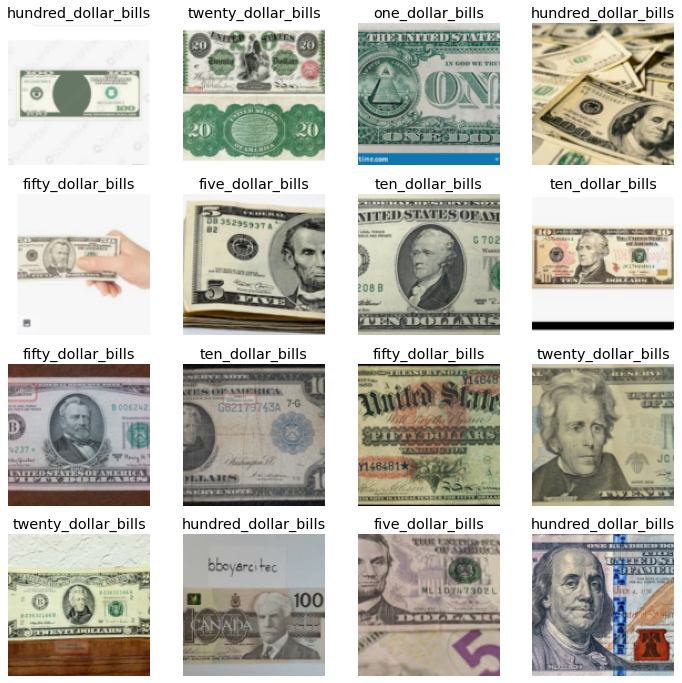

In [7]:
# Load data from directory
dl = db.dataloaders(path)
dl.valid.show_batch(max_n=16, nrows=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\aleck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


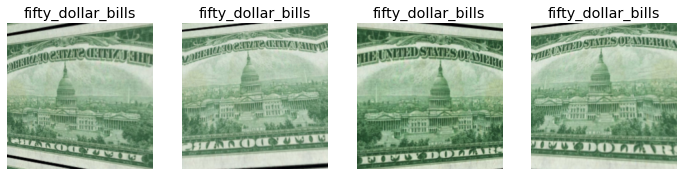

In [8]:
# Augment data and transform to same size
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dl = db.dataloaders(path)
dl.train.show_batch(max_n=4, nrows=1, unique=True)

In [13]:
# Train data with resnet, 18 layer neural network
model = cnn_learner(dl, resnet18, metrics=error_rate)
model.fine_tune(4)

# Note: Accuracy of model is 1 - error_rate

epoch,train_loss,valid_loss,error_rate,time
0,2.433094,1.296741,0.445455,04:27


epoch,train_loss,valid_loss,error_rate,time
0,1.470961,0.981200,0.323636,06:02
1,1.170599,0.785498,0.263636,06:02
2,0.917145,0.646301,0.220000,07:13
3,0.738386,0.642240,0.207273,06:30


In [10]:
# Discard bad images
cleaner = ImageClassifierCleaner(model)
cleaner

In [11]:
# Remove bad data
for idx in cleaner.delete():
    try:
        cleaner.fns[idx].unlink()
    except:
        continue

# Move wrongly classified data to correct label
for idx, folder in cleaner.change():
    try:
        shutil.move(str(cleaner.fns[idx]), path/folder)
    except:
        continue

In [14]:
# Re-train data with cleaned data
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dl = db.dataloaders(path)

model = cnn_learner(dl, resnet18, metrics=error_rate)
model.fine_tune(4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,time
0,2.335663,1.188748,0.412727,04:37


epoch,train_loss,valid_loss,error_rate,time
0,1.357518,0.901062,0.325455,05:31
1,1.109031,0.703707,0.221818,06:58
2,0.845638,0.620882,0.201818,06:01
3,0.682119,0.600115,0.200000,05:58


In [15]:
# Export model to pkl
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]